In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow.compat.v2.feature_column as fc
from IPython.display import clear_output
from six.moves import urllib
from sklearn.metrics import roc_curve

clear_output()

# Import Data files

In [2]:
df_train = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
df_eval = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/eval.csv")
y_train = df_train.pop("survived")
y_eval = df_eval.pop("survived")
df_train.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


# Data Preparation

A few steps are required before we train a Gradient Boosted Tree Classifier with Tensorflow. We need to prepare features to be included in the model. The estimator needs to have a list of features to train the model. Hence, the column's data requires to be converted into a tensor.

In [3]:
columns = [column for column in df_train.columns]
categorical_columns = [column for column in df_train.columns if df_train[column].dtype=='object']
numerical_columns = list(set(columns)-set(categorical_columns))

We use feature_column.categorical_column_with_vocabulary_list(key, vocabulary_list) when our inputs are in string or integer format, and we have an in-memory vocabulary mapping each value to an integer ID. By default, out-of-vocabulary values are ignored. 

This is because we cannot feed strings directly to a model. Instead, we must first map them to numeric values. The categorical vocabulary columns provide a way to represent strings as a one-hot vector. The vocabulary can be passed as a list using categorical_column_with_vocabulary_list, or loaded from a file using categorical_column_with_vocabulary_file.

For input dictionary features, features[key] is either Tensor or SparseTensor. If Tensor, missing values can be represented by -1 for int and '' for string, which will be dropped by this feature column.

Lastly, the list features will have one-hot-encoded categorical variables. To do this conversion, we use feature_column.indicator_column() method.

In [4]:
features = []
for column in columns:
    if column in categorical_columns:
        vocabulary = df_train[column].unique()
        features.append(fc.indicator_column(fc.categorical_column_with_vocabulary_list(column, vocabulary)))
    else:
        features.append(fc.numeric_column(column, dtype=tf.float32))

We need a function that constructs the input data for evaluation. As per the TensorFlow2.0 api docs,  the evaluate function should construct and return one of the following: * A tf.data.Dataset object: Outputs of Dataset object must be a tuple (features, labels) with same constraints as below. * A tuple (features, labels): Where features is a tf.Tensor or a dictionary of string feature name to Tensor and labels is a Tensor or a dictionary of string label name to Tensor. Both features and labels are consumed by model_fn. They should satisfy the expectation of model_fn from inputs.

Now, we will wrap the dataframes with tf.data. 

Below is a utility function that creates a tf.data.Dataset object from a Pandas Dataframe. It creates tensor slices of tuples of (features, labels) as required. This will enable us to use feature columns as a bridge to map from the columns in the Pandas dataframe to features used to train the model. If we were working with a very large CSV file (so large that it does not fit into memory), we would use tf.data to read it from disk directly. 

In [5]:
# A utility method to create a tf.data dataset from a Pandas Dataframe

def transform_fn(df, label, epochs=10, shuffle=True, batch_size=32):
    def transform():
        batch_data = tf.data.Dataset.from_tensor_slices((dict(df), label))
        if shuffle:
            batch_data = batch_data.shuffle(123)
        batch_data = batch_data.batch(batch_size).repeat(epochs)
        return batch_data
    return transform

In [6]:
input_train_fn = transform_fn(df_train, y_train)
input_eval_fn = transform_fn(df_eval, y_eval, epochs=1, shuffle=False)

# Model creation

Now, we train a Gradient Boosted Tree model to classify instances. feature_columns requires an iterable containing all the feature columns used by the model. It needs the following arguments:

(a) n_batches_per_layer: the number of batches to collect statistics per layer. The total number of batches is total number of data divided by batch size, (b) n_trees: number trees to be created, and (c) max_depth: maximum depth of the tree to grow.

In [20]:
est = tf.estimator.BoostedTreesClassifier(feature_columns=features, n_trees=70, max_depth=5, n_batches_per_layer=30)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\91828\\AppData\\Local\\Temp\\tmp989jm1k4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001F778CB8240>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [21]:
est.train(input_train_fn)
result = est.evaluate(input_eval_fn)
clear_output()
for key in result:
    print(f"{key}: {result[key]}")

accuracy: 0.810606062412262
accuracy_baseline: 0.625
auc: 0.8399755358695984
auc_precision_recall: 0.8177907466888428
average_loss: 0.5483906269073486
label/mean: 0.375
loss: 0.5471654534339905
precision: 0.7634408473968506
prediction/mean: 0.45756348967552185
recall: 0.7171717286109924
global_step: 170


In [22]:
pred_dict = list(est.predict(input_eval_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dict])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\91828\AppData\Local\Temp\tmp989jm1k4\model.ckpt-170
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


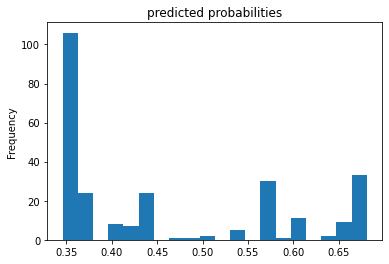

In [23]:
probs.plot(kind='hist', bins=20, title='predicted probabilities')

(0.0, 1.05)

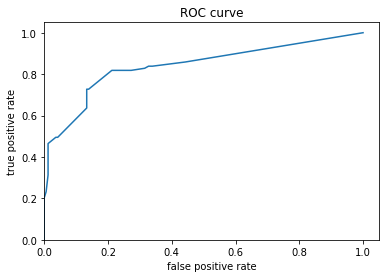

In [24]:
fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)

# Feature Importance

Additionally, we might want to understand the model as a whole. We will compute and use:

1. Gain-based feature importances using est.experimental_feature_importances
2. Permutation importances

Gain-based feature importances measure the loss change when splitting on a particular feature, while permutation feature importances are computed by evaluating model performance on the evaluation set by shuffling each feature one-by-one and attributing the change in model performance to the shuffled feature.

In general, permutation feature importance are preferred to gain-based feature importance, though both methods can be unreliable in situations where potential predictor variables vary in their scale of measurement or their number of categories and when features are correlated.

## Gain-based Feature Importance

Gain-based feature importances are built into the TensorFlow Boosted Trees estimators using est.experimental_feature_importances.

In [25]:
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

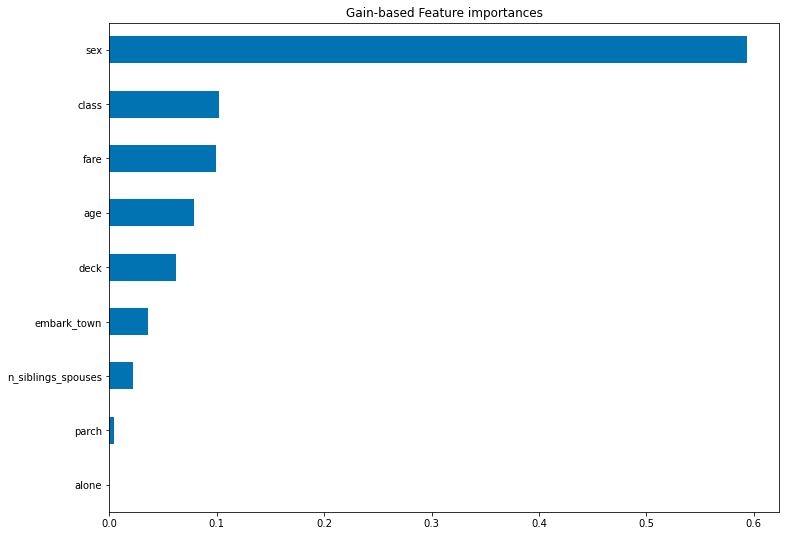

In [27]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
N = 9
ax = (df_imp.iloc[0:N][::-1].plot(kind='barh', color=sns_colors[0], title='Gain-based Feature importances', figsize=(12, 9)))
ax.grid(False, axis='y')

## Permutation Feature Importance

We shuffle values column by column and observe effect on eval set.

In [35]:
def permutation_importances(est, X_eval, y_eval, metric, features):
    baseline = metric(est, X_eval, y_eval)
    imp = []
    for col in features:
        save = X_eval[col].copy()
        X_eval[col] = np.random.permutation(X_eval[col])
        m = metric(est, X_eval, y_eval)
        X_eval[col] = save
        imp.append(baseline - m)
    return np.array(imp)

def accuracy_metric(est, X, y):
    eval_input_fn = transform_fn(X, y, shuffle=False, epochs=1)
    return est.evaluate(input_fn=input_eval_fn)['accuracy']

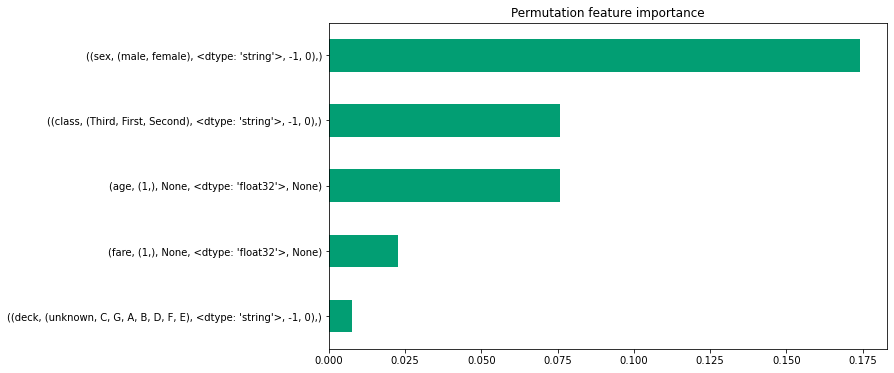

In [37]:
importances = permutation_importances(est, df_eval, y_eval, accuracy_metric, columns)
df_imp = pd.Series(importances, index=features)

sorted_ix = df_imp.abs().sort_values().index
clear_output()
ax = df_imp[sorted_ix][-5:].plot(kind='barh', color=sns_colors[2], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance')
plt.show()